# HW6: Naive Cross Validation
## 2022104346 정지헌

필요한 모듈 불러오기

In [50]:
import numpy as np
import matplotlib.pyplot as plt

모델과 Cost Function, Gradient Descent 정의
<br> DataLoader 클래스에 의해, raw data가 주어진 비율에 따라 training 데이터와 validation 데이터로 나뉜다.

In [51]:
class Model:
    def __init__(self):
        self.weights = None
        self.last_x = None
    
    def forward(self, x: np.ndarray):
        raise NotImplementedError
    
    def __call__(self, x: np.ndarray):
        return self.forward(x)
    
    def new_weights(self, new_w):
        self.weights = np.copy(new_w)

class CostFunction:
    def __init__(self, model: Model):
        self.grad = np.empty_like(model.weights)
        self.model = model
    
    def forward(self, x: np.ndarray, y: np.ndarray):
        raise NotImplementedError()
    
    def __call__(self, x: np.ndarray, y: np.ndarray):
        return self.forward(x, y)

class LinearModel(Model):
    def __init__(self, n: int):
        self.dim = n + 1
        self.weights = np.random.randn(self.dim)
        # (n + 1,)

    def forward(self, x: np.ndarray):
        assert self.weights.shape[-1] == x.shape[-1] == self.dim
        # x.shape == (p, n+1)
        # w_shape = (n+1,)

        dot_result = np.dot(x, self.weights)
        # (p, n+1) dot (n+1,) == (p,)

        return dot_result

In [ ]:
class MacLaurinSeries(LinearModel):
    def __init__(self, n: int):
        super().__init__(n)
        
    def forward(self, x):
        # x: (p,)
        
        self.last_x = np.ones((x.shape[0], self.dim))
        # (p, n+1)
        for i in range(1, self.dim):
            self.last_x[:,i] = self.last_x[:,i-1] * x
            # self.last_x[:,i]: (p,)

        dot_result = np.dot(self.last_x, self.weights)

        return dot_result
    

class LinearMSE(CostFunction):
    def __init__(self, model: Model):
        super().__init__(model)

    def forward(self, x: np.ndarray, y: np.ndarray):
        # x: (p, n+1)
        # y: (p,)
        # model weights: (n+1,)
        assert x.shape[0] == y.shape[0]

        model_result = self.model(x)
        # (p,)

        difference = model_result - y
        # (p,) - (p,) = (p,)
        difference_squared = np.square(difference)
        # (p,) square = (p,)
        
        cost = np.mean(difference_squared)
        # mean (p,) -> scalar
        grad_temp = self.model.last_x * difference[:, np.newaxis]
        # (p,)[:, np.newaxis] = (p, 1)
        # (p, n+1) * (p, 1) -> (p, n+1)

        self.grad = np.mean(grad_temp, axis = 0) * 2
        # mean((p, n+1), axis = 0) -> (n+1,)

        return cost, self.grad
        

class DataLoader:
    def __init__(self, raw_data: np.ndarray, validation_ratio):
        # raw_data: (data_count, 2)
        x_raw = raw_data[:,0]
        y_raw = raw_data[:,1]
        # x, y raw: (data_count,)

        data_count = raw_data.shape[0]
        validation_data_count = int(data_count * validation_ratio)
        shuffled_idxs = np.arange(data_count, dtype = np.int32)
        validation_idxs = shuffled_idxs[:validation_data_count]
        # (validation_data_count,)
        training_idxs = shuffled_idxs[validation_data_count:] 

        self.x_training_data = np.empty_like(training_idxs, dtype = np.float32)
        self.y_training_data = np.empty_like(training_idxs, dtype = np.float32)
        # (training_data_count,)

        self.x_validation_data = np.empty_like(validation_idxs, dtype = np.float32)
        self.y_validation_data = np.empty_like(validation_idxs, dtype = np.float32)
        # (validation_data_count,)

        for i, idx in enumerate(training_idxs):
            self.x_training_data[i] = x_raw[idx]
            self.y_training_data[i] = y_raw[idx]
        
        for i, idx in enumerate(validation_idxs):
            self.x_validation_data[i] = x_raw[idx]
            self.y_validation_data[i] = y_raw[idx]
    
    def load_training_data(self):
        return self.x_training_data, self.y_training_data
    
    def load_validation_data(self):
        return self.x_validation_data, self.y_validation_data
    
class GradientDescent:
    def __init__(self, model: Model, cost: CostFunction, data_loader: DataLoader):
        self.model = model
        self.cost = cost
        self.data_loader = data_loader

        self.cost_history = []
        self.weights_history = []

    def train(self, iteration_count: int, learning_rate: float):
        x_train_data, y_train_data = self.data_loader.load_training_data()

        for _ in range(iteration_count):
            temp_weights = np.copy(self.model.weights)
            temp_cost, grad = self.cost(x_train_data, y_train_data)

            self.cost_history.append(temp_cost)
            self.weights_history.append(temp_weights)
            
            temp_weights -= grad * learning_rate

            self.model.new_weights(temp_weights)
        
    def validate(self):
        x_validation_data, y_validation_data = self.data_loader.load_validation_data()
        
        validation_cost, _ = self.cost(x_validation_data, y_validation_data)

        return validation_cost

In [52]:
datapath = './'
raw_data = np.loadtxt(datapath + 'noisy_sin_sample.csv',delimiter = ',')

data_loader = DataLoader(raw_data, 0.3)

In [53]:
model_2 = MacLaurinSeries(2)
model_2_costfn = LinearMSE(model_2)
model_2_optimizer = GradientDescent(model_2, model_2_costfn, data_loader)
model_4 = MacLaurinSeries(4)
model_4_costfn = LinearMSE(model_4)
model_4_optimizer = GradientDescent(model_4, model_4_costfn, data_loader)
model_8 = MacLaurinSeries(8)
model_8_costfn = LinearMSE(model_8)
model_8_optimizer = GradientDescent(model_8, model_8_costfn, data_loader)

In [54]:
model_2_optimizer.train(600000, 1e-2)
model_4_optimizer.train(600000, 1e-2)
model_8_optimizer.train(600000, 1e-2)

model 4의 validation errror에 비해 model 8의 validation error가 더 높거나 유사하다. model 2는 training error와 validation error가 모두 다른 두 모델에 비해 높다. 따라서 model 4가 가장 적합한 복잡도를 가진 모델인 것으로 볼 수 있다.

In [55]:
print("model 2 training error:", model_2_optimizer.cost_history[-1], "model 2 validation error:", model_2_optimizer.validate())
print("model 4 training error:", model_4_optimizer.cost_history[-1], "model 4 validation error:", model_4_optimizer.validate())
print("model 8 training error:", model_8_optimizer.cost_history[-1], "model 8 validation error:", model_8_optimizer.validate())

model 2 training error: 0.11037652921281285 model 2 validation error: 0.3574900747403508
model 4 training error: 0.021896699614271875 model 4 validation error: 0.10758224308009308
model 8 training error: 0.022044992771830075 model 8 validation error: 0.13344436371978896


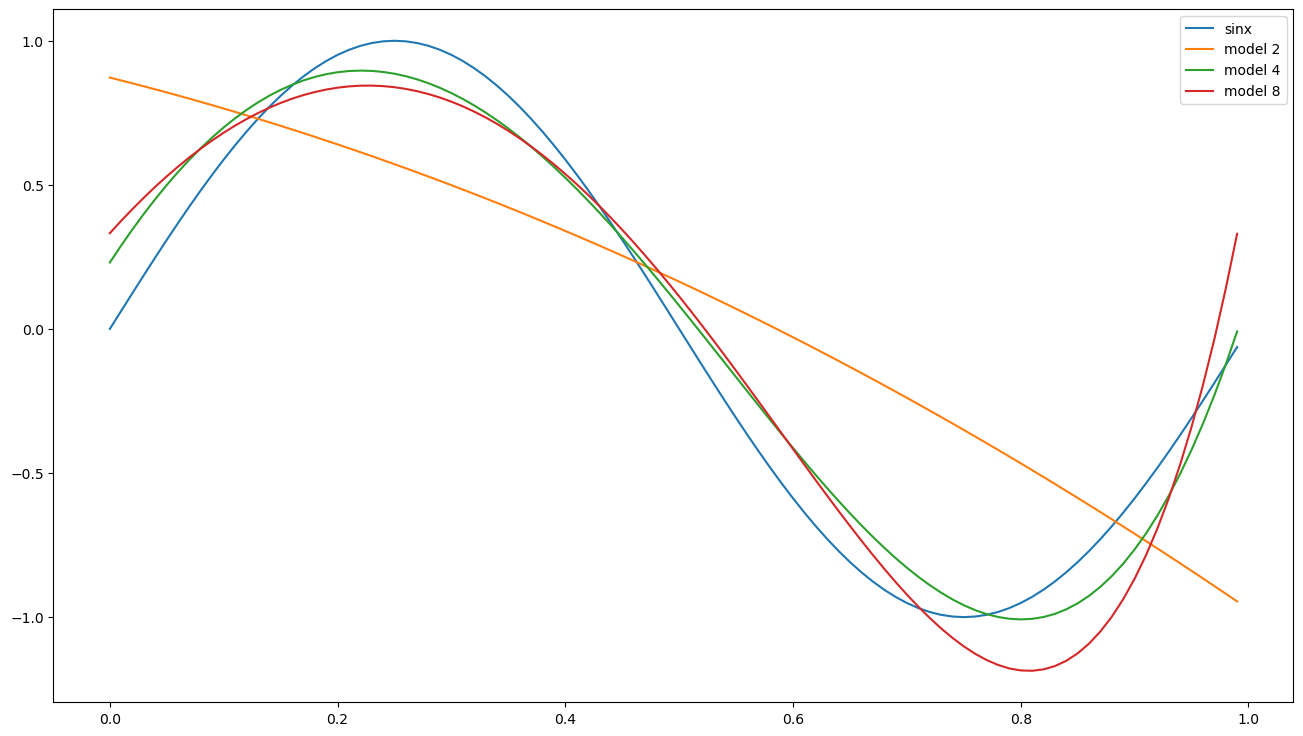

In [56]:
plt.figure(figsize=(16, 9))
base = np.arange(0, 1.0, 0.01)

plt.plot(base, np.sin(base * 2 * np.pi), label = "sinx")
plt.plot(base, model_2.forward(base), label = "model 2")
plt.plot(base, model_4.forward(base), label = "model 4")
plt.plot(base, model_8.forward(base), label = "model 8")
plt.legend()